# Userguide for the opern-source library SPFlow

SPFlow is an open-source functional-oriented Python package for Probabilistic Circuits (PCs) with ready-to-use implementations for Sum-Product Networks (SPNs). PCs are a class of powerful deep probabilistic models - expressible as directed acyclic graphs - that allow for tractable querying. This library provides routines for creating, learning, manipulating and interacting with PCs and is highly extensible and customizable.

## Create Toy Dataset

To demonstrate and visualize the main features of the library, we first create a 2D toy dataset with three Gaussian clusters, corresponding to labels 0, 1, and 2.
Each class contains 500 data points, for a total of 1,500 data points.

Dataset successfully created.
Shape of dataset: torch.Size([1500, 2])
Shape of labels: torch.Size([1500])
First 5 samples:
tensor([[ 3.1531, -2.8758],
        [ 3.2754, -1.3647],
        [ 3.8474, -2.7242],
        [-1.3886,  2.3674],
        [ 4.1169, -2.3614]])
Corresponding labels:
tensor([2, 2, 2, 0, 2])


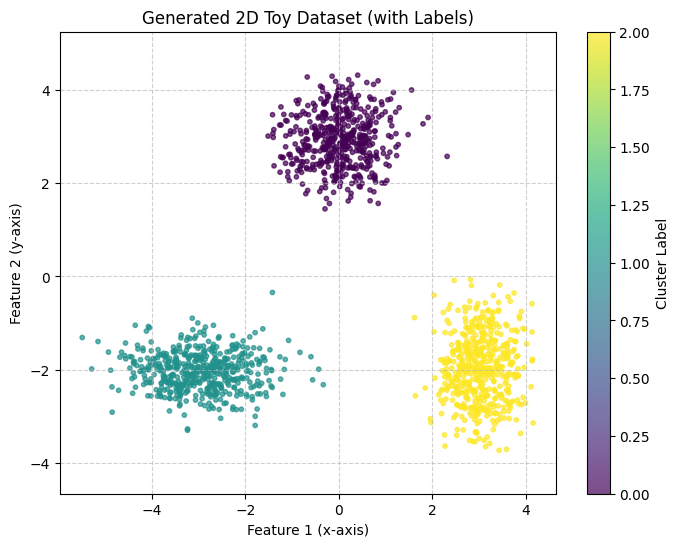

In [1]:
import torch
import matplotlib.pyplot as plt

# --- 1. Define the parameters for our dataset ---

n_points_per_cluster = 500

means = torch.tensor([
    [0.0, 3.0],   # Cluster 0
    [-3.0, -2.0], # Cluster 1
    [3.0, -2.0]   # Cluster 2
])

stds = torch.tensor([
    [0.6, 0.6],
    [0.8, 0.4],
    [0.5, 0.7]
])

# --- 2. Generate the data and labels ---

all_clusters = []
all_labels = []

for i in range(means.shape[0]):
    samples = (torch.randn(n_points_per_cluster, 2) * stds[i]) + means[i]
    labels = torch.full((n_points_per_cluster,), i, dtype=torch.long)  # label = cluster index
    all_clusters.append(samples)
    all_labels.append(labels)

# Concatenate all data and labels
dataset = torch.cat(all_clusters)
labels = torch.cat(all_labels)

# --- 3. Shuffle dataset and labels together ---

shuffled_indices = torch.randperm(dataset.shape[0])
dataset = dataset[shuffled_indices]
labels = labels[shuffled_indices]

# --- 4. Display some info ---

print("Dataset successfully created.")
print(f"Shape of dataset: {dataset.shape}")
print(f"Shape of labels: {labels.shape}")
print("First 5 samples:")
print(dataset[:5])
print("Corresponding labels:")
print(labels[:5])

# --- 5. Visualize the labeled dataset ---

data_np = dataset.cpu().numpy()
labels_np = labels.cpu().numpy()

plt.figure(figsize=(8, 6))
plt.scatter(data_np[:, 0], data_np[:, 1], c=labels_np, cmap='viridis', s=10, alpha=0.7)
plt.title('Generated 2D Toy Dataset (with Labels)')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal')
plt.colorbar(label='Cluster Label')
plt.show()



## Model Configuration
Below we manually create a simple Sum-Product Network by stacking leaf, product, and sum-layers

In [2]:
from spflow.modules.leaf import Normal
from spflow.modules import Sum
from spflow.modules import Product
from spflow.meta.data import Scope
from IPython.display import SVG, display

scope = Scope([0,1])

leaf_layer = Normal(scope=scope, out_channels=6)
product_layer = Product(inputs=leaf_layer)
spn = Sum(inputs=product_layer, out_channels=1)
spn

Sum(
  D=1, C=1, R=None, weights=(1, 6, 1)
  (inputs): Product(
    D=1, C=6, R=None
    (inputs): Normal(
      D=2, C=6, R=None
      (distribution): Normal()
    )
  )
)

Below is a visualization of the SPN defined above.
The number of output channels of a sum or leaf layer is equivalent to the number of nodes in that layer.
The number of nodes in a product layer is derived from the number of nodes in its input.

In [3]:
display(SVG(filename='StandardSPN.svg'))

Next, we can train the SPN, for example, using gradient descent.
The library already provides a method for training an SPN with gradient descent.
To do this, simply pass your training parameters such as the number of epochs, learning rate, etc.

In [4]:
from spflow.learn import train_gradient_descent
from torch.utils.data import DataLoader, TensorDataset
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s"
)

train_dataset = TensorDataset(dataset)
dataloader = DataLoader(train_dataset, batch_size=10)
train_gradient_descent(spn, dataloader, epochs=10, lr=0.1, verbose=True)

2025-10-16 16:51:10,891 [INFO] spflow.learn.gradient_descent: Epoch [0/10]: Loss: 32.41105651855469


Time taken for epoch:  0.5209958553314209


2025-10-16 16:51:11,297 [INFO] spflow.learn.gradient_descent: Epoch [1/10]: Loss: 30.965059280395508


Time taken for epoch:  0.4030017852783203


2025-10-16 16:51:11,737 [INFO] spflow.learn.gradient_descent: Epoch [2/10]: Loss: 30.831218719482422


Time taken for epoch:  0.43799734115600586


2025-10-16 16:51:12,176 [INFO] spflow.learn.gradient_descent: Epoch [3/10]: Loss: 30.83942985534668


Time taken for epoch:  0.4370005130767822


2025-10-16 16:51:12,574 [INFO] spflow.learn.gradient_descent: Epoch [4/10]: Loss: 30.762495040893555


Time taken for epoch:  0.39600300788879395


2025-10-16 16:51:12,981 [INFO] spflow.learn.gradient_descent: Epoch [5/10]: Loss: 29.011999130249023


Time taken for epoch:  0.4049973487854004


2025-10-16 16:51:13,419 [INFO] spflow.learn.gradient_descent: Epoch [6/10]: Loss: 29.029611587524414


Time taken for epoch:  0.43599843978881836


2025-10-16 16:51:13,828 [INFO] spflow.learn.gradient_descent: Epoch [7/10]: Loss: 28.9261474609375


Time taken for epoch:  0.40799784660339355


2025-10-16 16:51:14,259 [INFO] spflow.learn.gradient_descent: Epoch [8/10]: Loss: 28.888256072998047


Time taken for epoch:  0.42899537086486816


2025-10-16 16:51:14,740 [INFO] spflow.learn.gradient_descent: Epoch [9/10]: Loss: 28.865863800048828


Time taken for epoch:  0.4790010452270508


Once the SPN is trained, we can perform queries such as inference and sampling.
SPFlow uses internal dispatching so that a single query function can work across all module types.
For example, the log_likelihood method shown below can be used for every SPN model encountered throughout this guide.

In [5]:
from spflow import log_likelihood

ll = log_likelihood(spn, dataset)
ll

tensor([[[-2.6255]],

        [[-2.3601]],

        [[-3.9246]],

        ...,

        [[-2.2838]],

        [[-3.8238]],

        [[-3.7337]]], grad_fn=<ViewBackward0>)

Finally, we can visualize the training results on our toy dataset.

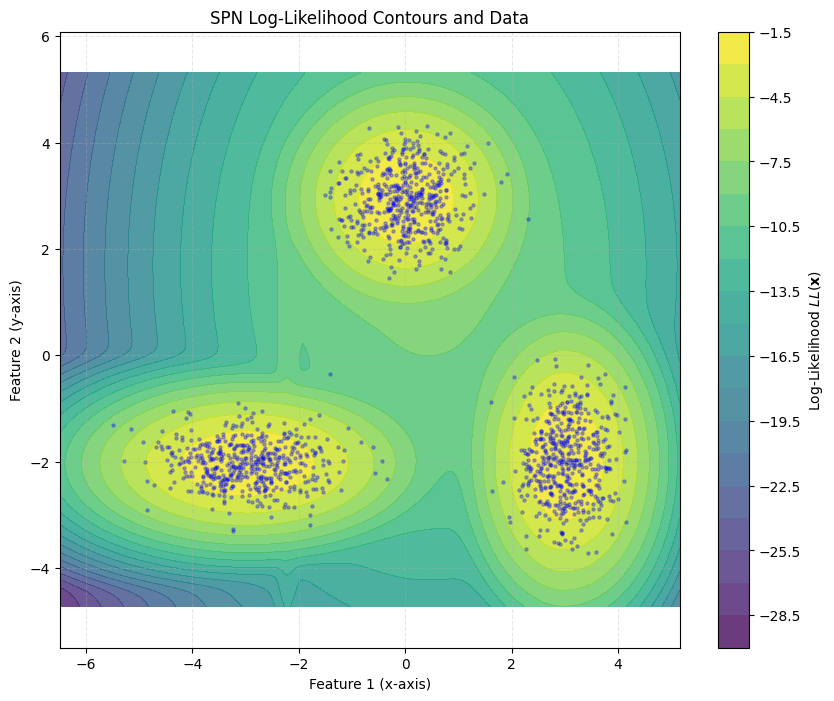

In [6]:
import numpy as np
data_np = dataset.cpu().numpy()

# Define the boundaries of the plot with a small padding
x_min, x_max = data_np[:, 0].min() - 1, data_np[:, 0].max() + 1
y_min, y_max = data_np[:, 1].min() - 1, data_np[:, 1].max() + 1

# Create a grid of points
grid_resolution = 200
xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_resolution),
                     np.linspace(y_min, y_max, grid_resolution))

# Stack the grid points into a format our function can accept: [n_points, 2]
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
ll = log_likelihood(spn, grid_points)
# Reshape the LL values to match the grid shape for plotting
Z = ll.detach().cpu().numpy().reshape(xx.shape)


# --- 6. Visualize the Data and Log-Likelihood Contours ---

plt.figure(figsize=(10, 8))

# Plot the filled contour map of the log-likelihood
# Higher values (brighter colors) mean the model thinks data is more likely there
contour = plt.contourf(xx, yy, Z, levels=20, cmap='viridis', alpha=0.8)

# Add a color bar to show the LL scale
plt.colorbar(contour, label='Log-Likelihood $LL(\mathbf{x})$')

# Overlay the scatter plot of the actual data points
# We make them semi-transparent and small to see the density and contours
plt.scatter(data_np[:, 0], data_np[:, 1], s=5, alpha=0.3, c='blue')

# Add titles and labels
plt.title('SPN Log-Likelihood Contours and Data')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal') # Ensures the scaling is the same on both axes
plt.show()


## Automatic Model creation
Besides creating an SPN manually by stacking layers, it is also possible to use algorithms to automatically construct the SPN architecture.

###  Rat-SPN
The Rat-SPN algorithm builds a deep network structure by recursively partitioning the features (variables) into random subsets and alternating between sum and product layers.
Below, we set up a Rat-SPN by defining its structure and parameters.

In [7]:
from spflow.modules.rat.rat_spn import RatSPN
depth = 1
n_region_nodes = 3
num_leaves = 2
num_repetitions = 2
n_root_nodes = 1
num_feature = 2

scope = Scope(list(range(0, num_feature)))

rat_leaf_layer = Normal(scope=scope, out_channels=num_leaves, num_repetitions=num_repetitions)
rat = RatSPN(
    leaf_modules=[rat_leaf_layer],
    n_root_nodes=n_root_nodes,
    n_region_nodes=n_region_nodes,
    num_repetitions=num_repetitions,
    depth=depth,
    outer_product=True,
    split_halves=True,
)
rat

RatSPN(
  D=1, C=1, R=2
  (root_node): MixingLayer(
    D=1, C=1, R=2, weights=(1, 2, 1)
    (inputs): Sum(
      D=1, C=1, R=2, weights=(1, 4, 1, 2)
      (inputs): OuterProduct(
        D=1, C=4, R=2
        (inputs): ModuleList(
          (0): SplitHalves(
            D=2, C=2, R=2, dim=1
            (inputs): ModuleList(
              (0): Factorize(
                D=2, C=2, R=2
                (inputs): ModuleList(
                  (0): Normal(
                    D=2, C=2, R=2
                    (distribution): Normal()
                  )
                )
              )
            )
          )
        )
      )
    )
  )
)

Here is a visualization of the architecture we just created.

In [8]:
display(SVG(filename='Rat_SPN.svg'))

In [9]:
ll = log_likelihood(rat, dataset)
ll

tensor([[[-11.6365]],

        [[ -7.5571]],

        [[-12.5652]],

        ...,

        [[ -7.9615]],

        [[ -4.9929]],

        [[ -3.1901]]], grad_fn=<ViewBackward0>)

We can again train this model using the provided gradient descent method.

In [10]:
train_gradient_descent(rat, dataloader, epochs=20, lr=0.1)

Time taken for epoch:  0.6060028076171875
Time taken for epoch:  0.574995756149292
Time taken for epoch:  0.6269979476928711
Time taken for epoch:  0.6019978523254395
Time taken for epoch:  0.6540002822875977
Time taken for epoch:  0.6160006523132324
Time taken for epoch:  0.5980014801025391
Time taken for epoch:  0.5549983978271484
Time taken for epoch:  0.5869998931884766
Time taken for epoch:  0.628997802734375
Time taken for epoch:  0.6240015029907227
Time taken for epoch:  0.665003776550293
Time taken for epoch:  0.6739990711212158
Time taken for epoch:  0.6400017738342285
Time taken for epoch:  0.5859980583190918
Time taken for epoch:  0.5689945220947266
Time taken for epoch:  0.588003396987915
Time taken for epoch:  0.553999662399292
Time taken for epoch:  0.6149985790252686
Time taken for epoch:  0.5689988136291504


o verify that the training worked properly, we can visualize the log-likelihoods of the trained model.

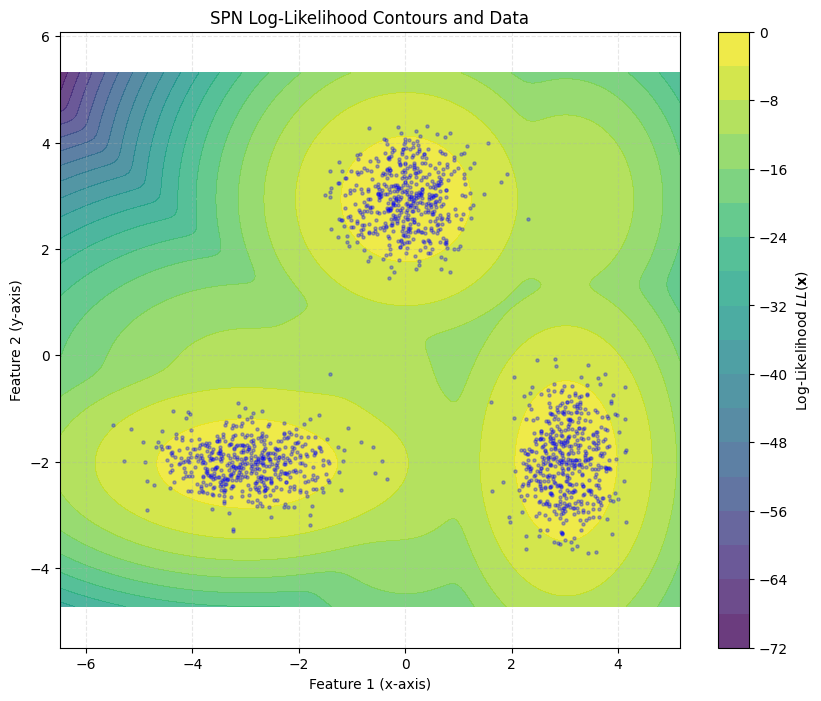

In [11]:
import numpy as np
data_np = dataset.cpu().numpy()

# Define the boundaries of the plot with a small padding
x_min, x_max = data_np[:, 0].min() - 1, data_np[:, 0].max() + 1
y_min, y_max = data_np[:, 1].min() - 1, data_np[:, 1].max() + 1

# Create a grid of points
grid_resolution = 200
xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_resolution),
                     np.linspace(y_min, y_max, grid_resolution))

# Stack the grid points into a format our function can accept: [n_points, 2]
grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
ll = log_likelihood(rat, grid_points)
# Reshape the LL values to match the grid shape for plotting
Z = ll.detach().cpu().numpy().reshape(xx.shape)


# --- 6. Visualize the Data and Log-Likelihood Contours ---

plt.figure(figsize=(10, 8))

# Plot the filled contour map of the log-likelihood
# Higher values (brighter colors) mean the model thinks data is more likely there
contour = plt.contourf(xx, yy, Z, levels=20, cmap='viridis', alpha=0.8)

# Add a color bar to show the LL scale
plt.colorbar(contour, label='Log-Likelihood $LL(\mathbf{x})$')

# Overlay the scatter plot of the actual data points
# We make them semi-transparent and small to see the density and contours
plt.scatter(data_np[:, 0], data_np[:, 1], s=5, alpha=0.3, c='blue')

# Add titles and labels
plt.title('SPN Log-Likelihood Contours and Data')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.3)
plt.axis('equal') # Ensures the scaling is the same on both axes
plt.show()

Of course, computing log-likelihoods is not the only thing the model can do.
Below is a visualization of samples drawn from the trained Rat-SPN.

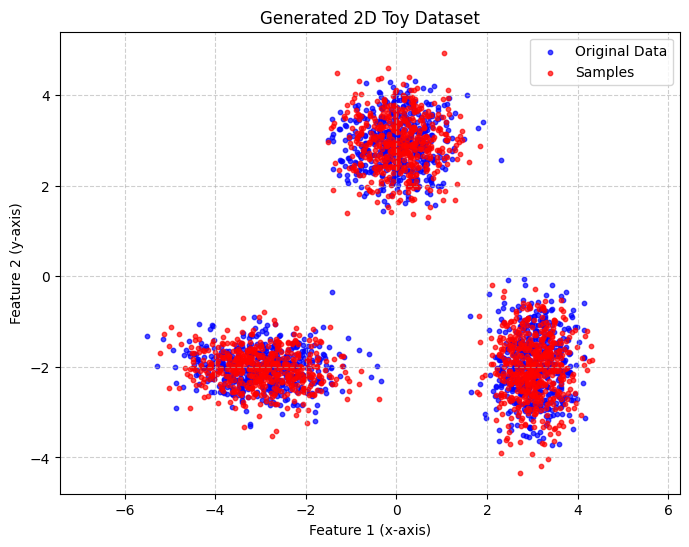

In [12]:
from spflow import sample

samples = sample(spn, 1500)

plt.figure(figsize=(8, 6))
# We use a scatter plot. data_np[:, 0] is the x-axis, data_np[:, 1] is the y-axis
plt.scatter(data_np[:, 0], data_np[:, 1], s=10, alpha=0.7, c='blue', label='Original Data')
plt.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.7, c='red', label='Samples')
plt.title('Generated 2D Toy Dataset')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal') # Ensures the scaling is the same on both axes
plt.legend()
plt.show()


Up to now, we have focused only on generation, without considering the labels of the training instances.
Next, we will train a second Rat-SPN for classification.

In [13]:
import logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s"
)

depth = 1
n_region_nodes = 1
num_leaves = 10
num_repetitions = 1
n_root_nodes = 3
num_feature = 2

scope = Scope(list(range(0, num_feature)))

rat_leaf_layer = Normal(scope=scope, out_channels=num_leaves, num_repetitions=num_repetitions)
rat = RatSPN(
    leaf_modules=[rat_leaf_layer],
    n_root_nodes=n_root_nodes,
    n_region_nodes=n_region_nodes,
    num_repetitions=num_repetitions,
    depth=depth,
    outer_product=True,
    split_halves=True,
)
train_dataset = TensorDataset(dataset, labels)
dataloader_with_labels = DataLoader(train_dataset, batch_size=10)

train_gradient_descent(rat.root_node.inputs, dataloader_with_labels, epochs=100, lr=0.001, is_classification=True, verbose=True)



2025-10-16 16:51:29,336 [INFO] spflow.learn.gradient_descent: Epoch [0/100]: Loss: 10.309064865112305


Time taken for epoch:  0.7030019760131836
Accuracy: 54.0


2025-10-16 16:51:29,977 [INFO] spflow.learn.gradient_descent: Epoch [1/100]: Loss: 8.326894760131836


Time taken for epoch:  0.6389970779418945
Accuracy: 90.86666666666666


2025-10-16 16:51:30,618 [INFO] spflow.learn.gradient_descent: Epoch [2/100]: Loss: 6.607431888580322


Time taken for epoch:  0.6389999389648438
Accuracy: 95.2


2025-10-16 16:51:31,246 [INFO] spflow.learn.gradient_descent: Epoch [3/100]: Loss: 5.48714542388916


Time taken for epoch:  0.6270034313201904
Accuracy: 97.0


2025-10-16 16:51:31,882 [INFO] spflow.learn.gradient_descent: Epoch [4/100]: Loss: 4.818907737731934


Time taken for epoch:  0.6330029964447021
Accuracy: 98.6


2025-10-16 16:51:32,551 [INFO] spflow.learn.gradient_descent: Epoch [5/100]: Loss: 4.344321250915527


Time taken for epoch:  0.6680002212524414
Accuracy: 98.86666666666666


2025-10-16 16:51:33,078 [INFO] spflow.learn.gradient_descent: Epoch [6/100]: Loss: 3.9813530445098877


Time taken for epoch:  0.5249996185302734
Accuracy: 99.2


2025-10-16 16:51:33,606 [INFO] spflow.learn.gradient_descent: Epoch [7/100]: Loss: 3.6954562664031982


Time taken for epoch:  0.5260004997253418
Accuracy: 100.0


2025-10-16 16:51:34,155 [INFO] spflow.learn.gradient_descent: Epoch [8/100]: Loss: 3.4671127796173096


Time taken for epoch:  0.5479998588562012
Accuracy: 99.93333333333334


2025-10-16 16:51:34,647 [INFO] spflow.learn.gradient_descent: Epoch [9/100]: Loss: 3.2823715209960938


Time taken for epoch:  0.4909987449645996
Accuracy: 99.93333333333334


2025-10-16 16:51:35,135 [INFO] spflow.learn.gradient_descent: Epoch [10/100]: Loss: 3.129737138748169


Time taken for epoch:  0.48499584197998047
Accuracy: 99.93333333333334


2025-10-16 16:51:35,595 [INFO] spflow.learn.gradient_descent: Epoch [11/100]: Loss: 3.0000829696655273


Time taken for epoch:  0.4590005874633789
Accuracy: 99.93333333333334


2025-10-16 16:51:35,963 [INFO] spflow.learn.gradient_descent: Epoch [12/100]: Loss: 2.8867452144622803


Time taken for epoch:  0.3659989833831787
Accuracy: 99.93333333333334


2025-10-16 16:51:36,350 [INFO] spflow.learn.gradient_descent: Epoch [13/100]: Loss: 2.7850797176361084


Time taken for epoch:  0.3860018253326416
Accuracy: 100.0


2025-10-16 16:51:36,717 [INFO] spflow.learn.gradient_descent: Epoch [14/100]: Loss: 2.692073345184326


Time taken for epoch:  0.3659989833831787
Accuracy: 100.0


2025-10-16 16:51:37,076 [INFO] spflow.learn.gradient_descent: Epoch [15/100]: Loss: 2.6061718463897705


Time taken for epoch:  0.35699939727783203
Accuracy: 100.0


2025-10-16 16:51:37,442 [INFO] spflow.learn.gradient_descent: Epoch [16/100]: Loss: 2.526805877685547


Time taken for epoch:  0.36499810218811035
Accuracy: 100.0


2025-10-16 16:51:37,808 [INFO] spflow.learn.gradient_descent: Epoch [17/100]: Loss: 2.453559398651123


Time taken for epoch:  0.36499881744384766
Accuracy: 100.0


2025-10-16 16:51:38,164 [INFO] spflow.learn.gradient_descent: Epoch [18/100]: Loss: 2.3857810497283936


Time taken for epoch:  0.35503625869750977
Accuracy: 100.0


2025-10-16 16:51:38,521 [INFO] spflow.learn.gradient_descent: Epoch [19/100]: Loss: 2.3227896690368652


Time taken for epoch:  0.3560006618499756
Accuracy: 100.0


2025-10-16 16:51:38,875 [INFO] spflow.learn.gradient_descent: Epoch [20/100]: Loss: 2.2640810012817383


Time taken for epoch:  0.3529996871948242
Accuracy: 100.0


2025-10-16 16:51:39,235 [INFO] spflow.learn.gradient_descent: Epoch [21/100]: Loss: 2.2093756198883057


Time taken for epoch:  0.35899829864501953
Accuracy: 100.0


2025-10-16 16:51:39,603 [INFO] spflow.learn.gradient_descent: Epoch [22/100]: Loss: 2.158595561981201


Time taken for epoch:  0.36700010299682617
Accuracy: 100.0


2025-10-16 16:51:39,962 [INFO] spflow.learn.gradient_descent: Epoch [23/100]: Loss: 2.1118180751800537


Time taken for epoch:  0.35700273513793945
Accuracy: 100.0


2025-10-16 16:51:40,317 [INFO] spflow.learn.gradient_descent: Epoch [24/100]: Loss: 2.069216728210449


Time taken for epoch:  0.3536190986633301
Accuracy: 100.0


2025-10-16 16:51:40,688 [INFO] spflow.learn.gradient_descent: Epoch [25/100]: Loss: 2.030996799468994


Time taken for epoch:  0.3710193634033203
Accuracy: 100.0


2025-10-16 16:51:41,053 [INFO] spflow.learn.gradient_descent: Epoch [26/100]: Loss: 1.9973195791244507


Time taken for epoch:  0.36299777030944824
Accuracy: 100.0


2025-10-16 16:51:41,422 [INFO] spflow.learn.gradient_descent: Epoch [27/100]: Loss: 1.9682153463363647


Time taken for epoch:  0.3690030574798584
Accuracy: 100.0


2025-10-16 16:51:41,797 [INFO] spflow.learn.gradient_descent: Epoch [28/100]: Loss: 1.9435193538665771


Time taken for epoch:  0.37400007247924805
Accuracy: 100.0


2025-10-16 16:51:42,160 [INFO] spflow.learn.gradient_descent: Epoch [29/100]: Loss: 1.9228522777557373


Time taken for epoch:  0.36052417755126953
Accuracy: 100.0


2025-10-16 16:51:42,532 [INFO] spflow.learn.gradient_descent: Epoch [30/100]: Loss: 1.9056708812713623


Time taken for epoch:  0.37099790573120117
Accuracy: 100.0


2025-10-16 16:51:42,957 [INFO] spflow.learn.gradient_descent: Epoch [31/100]: Loss: 1.891366720199585


Time taken for epoch:  0.42299985885620117
Accuracy: 100.0


2025-10-16 16:51:43,353 [INFO] spflow.learn.gradient_descent: Epoch [32/100]: Loss: 1.8793704509735107


Time taken for epoch:  0.39499974250793457
Accuracy: 100.0


2025-10-16 16:51:43,728 [INFO] spflow.learn.gradient_descent: Epoch [33/100]: Loss: 1.8692102432250977


Time taken for epoch:  0.37400126457214355
Accuracy: 100.0


2025-10-16 16:51:44,111 [INFO] spflow.learn.gradient_descent: Epoch [34/100]: Loss: 1.8605220317840576


Time taken for epoch:  0.3820011615753174
Accuracy: 100.0


2025-10-16 16:51:44,490 [INFO] spflow.learn.gradient_descent: Epoch [35/100]: Loss: 1.8530362844467163


Time taken for epoch:  0.37799835205078125
Accuracy: 100.0


2025-10-16 16:51:44,892 [INFO] spflow.learn.gradient_descent: Epoch [36/100]: Loss: 1.8465478420257568


Time taken for epoch:  0.4009997844696045
Accuracy: 100.0


2025-10-16 16:51:45,255 [INFO] spflow.learn.gradient_descent: Epoch [37/100]: Loss: 1.8408960103988647


Time taken for epoch:  0.3619973659515381
Accuracy: 100.0


2025-10-16 16:51:45,621 [INFO] spflow.learn.gradient_descent: Epoch [38/100]: Loss: 1.8359521627426147


Time taken for epoch:  0.36500072479248047
Accuracy: 100.0


2025-10-16 16:51:45,995 [INFO] spflow.learn.gradient_descent: Epoch [39/100]: Loss: 1.8316097259521484


Time taken for epoch:  0.37200021743774414
Accuracy: 100.0


2025-10-16 16:51:46,366 [INFO] spflow.learn.gradient_descent: Epoch [40/100]: Loss: 1.8277785778045654


Time taken for epoch:  0.36999988555908203
Accuracy: 100.0


2025-10-16 16:51:46,743 [INFO] spflow.learn.gradient_descent: Epoch [41/100]: Loss: 1.8243849277496338


Time taken for epoch:  0.3750004768371582
Accuracy: 100.0


2025-10-16 16:51:47,107 [INFO] spflow.learn.gradient_descent: Epoch [42/100]: Loss: 1.821364402770996


Time taken for epoch:  0.36208581924438477
Accuracy: 100.0


2025-10-16 16:51:47,472 [INFO] spflow.learn.gradient_descent: Epoch [43/100]: Loss: 1.8186652660369873


Time taken for epoch:  0.36299967765808105
Accuracy: 100.0


2025-10-16 16:51:47,840 [INFO] spflow.learn.gradient_descent: Epoch [44/100]: Loss: 1.8162450790405273


Time taken for epoch:  0.3679978847503662
Accuracy: 100.0


2025-10-16 16:51:48,252 [INFO] spflow.learn.gradient_descent: Epoch [45/100]: Loss: 1.8140655755996704


Time taken for epoch:  0.4100167751312256
Accuracy: 100.0


2025-10-16 16:51:48,623 [INFO] spflow.learn.gradient_descent: Epoch [46/100]: Loss: 1.812095284461975


Time taken for epoch:  0.3710002899169922
Accuracy: 100.0


2025-10-16 16:51:49,001 [INFO] spflow.learn.gradient_descent: Epoch [47/100]: Loss: 1.810309648513794


Time taken for epoch:  0.3770003318786621
Accuracy: 100.0


2025-10-16 16:51:49,382 [INFO] spflow.learn.gradient_descent: Epoch [48/100]: Loss: 1.8086868524551392


Time taken for epoch:  0.38106656074523926
Accuracy: 100.0


2025-10-16 16:51:49,751 [INFO] spflow.learn.gradient_descent: Epoch [49/100]: Loss: 1.8072080612182617


Time taken for epoch:  0.36795878410339355
Accuracy: 100.0


2025-10-16 16:51:50,133 [INFO] spflow.learn.gradient_descent: Epoch [50/100]: Loss: 1.8066400289535522


Time taken for epoch:  0.3800010681152344
Accuracy: 100.0


2025-10-16 16:51:50,506 [INFO] spflow.learn.gradient_descent: Epoch [51/100]: Loss: 1.8064085245132446


Time taken for epoch:  0.37199878692626953
Accuracy: 100.0


2025-10-16 16:51:50,884 [INFO] spflow.learn.gradient_descent: Epoch [52/100]: Loss: 1.8061784505844116


Time taken for epoch:  0.3765244483947754
Accuracy: 100.0


2025-10-16 16:51:51,264 [INFO] spflow.learn.gradient_descent: Epoch [53/100]: Loss: 1.8059486150741577


Time taken for epoch:  0.37852025032043457
Accuracy: 100.0


2025-10-16 16:51:51,656 [INFO] spflow.learn.gradient_descent: Epoch [54/100]: Loss: 1.805718183517456


Time taken for epoch:  0.39151620864868164
Accuracy: 100.0


2025-10-16 16:51:52,042 [INFO] spflow.learn.gradient_descent: Epoch [55/100]: Loss: 1.8054885864257812


Time taken for epoch:  0.38453030586242676
Accuracy: 100.0


2025-10-16 16:51:52,421 [INFO] spflow.learn.gradient_descent: Epoch [56/100]: Loss: 1.8052594661712646


Time taken for epoch:  0.3769989013671875
Accuracy: 100.0


2025-10-16 16:51:52,888 [INFO] spflow.learn.gradient_descent: Epoch [57/100]: Loss: 1.8050295114517212


Time taken for epoch:  0.4665191173553467
Accuracy: 100.0


2025-10-16 16:51:53,270 [INFO] spflow.learn.gradient_descent: Epoch [58/100]: Loss: 1.8047988414764404


Time taken for epoch:  0.38152146339416504
Accuracy: 100.0


2025-10-16 16:51:53,651 [INFO] spflow.learn.gradient_descent: Epoch [59/100]: Loss: 1.8045679330825806


Time taken for epoch:  0.3796067237854004
Accuracy: 100.0


2025-10-16 16:51:54,035 [INFO] spflow.learn.gradient_descent: Epoch [60/100]: Loss: 1.8043367862701416


Time taken for epoch:  0.38362765312194824
Accuracy: 100.0


2025-10-16 16:51:54,408 [INFO] spflow.learn.gradient_descent: Epoch [61/100]: Loss: 1.8041045665740967


Time taken for epoch:  0.3709983825683594
Accuracy: 100.0


2025-10-16 16:51:54,766 [INFO] spflow.learn.gradient_descent: Epoch [62/100]: Loss: 1.8038723468780518


Time taken for epoch:  0.3559997081756592
Accuracy: 100.0


2025-10-16 16:51:55,151 [INFO] spflow.learn.gradient_descent: Epoch [63/100]: Loss: 1.8036400079727173


Time taken for epoch:  0.38352179527282715
Accuracy: 100.0


2025-10-16 16:51:55,516 [INFO] spflow.learn.gradient_descent: Epoch [64/100]: Loss: 1.8034067153930664


Time taken for epoch:  0.36400389671325684
Accuracy: 100.0


2025-10-16 16:51:55,872 [INFO] spflow.learn.gradient_descent: Epoch [65/100]: Loss: 1.803174376487732


Time taken for epoch:  0.35452771186828613
Accuracy: 100.0


2025-10-16 16:51:56,244 [INFO] spflow.learn.gradient_descent: Epoch [66/100]: Loss: 1.8029413223266602


Time taken for epoch:  0.37052416801452637
Accuracy: 100.0


2025-10-16 16:51:56,599 [INFO] spflow.learn.gradient_descent: Epoch [67/100]: Loss: 1.802709937095642


Time taken for epoch:  0.3549995422363281
Accuracy: 100.0


2025-10-16 16:51:56,960 [INFO] spflow.learn.gradient_descent: Epoch [68/100]: Loss: 1.8024791479110718


Time taken for epoch:  0.3600020408630371
Accuracy: 100.0


2025-10-16 16:51:57,328 [INFO] spflow.learn.gradient_descent: Epoch [69/100]: Loss: 1.8022493124008179


Time taken for epoch:  0.3670022487640381
Accuracy: 100.0


2025-10-16 16:51:57,686 [INFO] spflow.learn.gradient_descent: Epoch [70/100]: Loss: 1.8020200729370117


Time taken for epoch:  0.35700082778930664
Accuracy: 100.0


2025-10-16 16:51:58,050 [INFO] spflow.learn.gradient_descent: Epoch [71/100]: Loss: 1.8017921447753906


Time taken for epoch:  0.36299800872802734
Accuracy: 100.0


2025-10-16 16:51:58,423 [INFO] spflow.learn.gradient_descent: Epoch [72/100]: Loss: 1.8015655279159546


Time taken for epoch:  0.37199878692626953
Accuracy: 100.0


2025-10-16 16:51:58,789 [INFO] spflow.learn.gradient_descent: Epoch [73/100]: Loss: 1.8013410568237305


Time taken for epoch:  0.36499881744384766
Accuracy: 100.0


2025-10-16 16:51:59,163 [INFO] spflow.learn.gradient_descent: Epoch [74/100]: Loss: 1.8011178970336914


Time taken for epoch:  0.3730032444000244
Accuracy: 100.0


2025-10-16 16:51:59,563 [INFO] spflow.learn.gradient_descent: Epoch [75/100]: Loss: 1.8010600805282593


Time taken for epoch:  0.3989982604980469
Accuracy: 100.0


2025-10-16 16:51:59,950 [INFO] spflow.learn.gradient_descent: Epoch [76/100]: Loss: 1.8010362386703491


Time taken for epoch:  0.3860020637512207
Accuracy: 100.0


2025-10-16 16:52:00,371 [INFO] spflow.learn.gradient_descent: Epoch [77/100]: Loss: 1.8010118007659912


Time taken for epoch:  0.41900086402893066
Accuracy: 100.0


2025-10-16 16:52:00,745 [INFO] spflow.learn.gradient_descent: Epoch [78/100]: Loss: 1.8009874820709229


Time taken for epoch:  0.37304258346557617
Accuracy: 100.0


2025-10-16 16:52:01,137 [INFO] spflow.learn.gradient_descent: Epoch [79/100]: Loss: 1.8009624481201172


Time taken for epoch:  0.39099979400634766
Accuracy: 100.0


2025-10-16 16:52:01,535 [INFO] spflow.learn.gradient_descent: Epoch [80/100]: Loss: 1.8009376525878906


Time taken for epoch:  0.3969993591308594
Accuracy: 100.0


2025-10-16 16:52:01,910 [INFO] spflow.learn.gradient_descent: Epoch [81/100]: Loss: 1.800912618637085


Time taken for epoch:  0.3734896183013916
Accuracy: 100.0


2025-10-16 16:52:02,329 [INFO] spflow.learn.gradient_descent: Epoch [82/100]: Loss: 1.8008874654769897


Time taken for epoch:  0.4165217876434326
Accuracy: 100.0


2025-10-16 16:52:02,732 [INFO] spflow.learn.gradient_descent: Epoch [83/100]: Loss: 1.8008620738983154


Time taken for epoch:  0.40152406692504883
Accuracy: 100.0


2025-10-16 16:52:03,119 [INFO] spflow.learn.gradient_descent: Epoch [84/100]: Loss: 1.8008372783660889


Time taken for epoch:  0.38551855087280273
Accuracy: 100.0


2025-10-16 16:52:03,522 [INFO] spflow.learn.gradient_descent: Epoch [85/100]: Loss: 1.800811529159546


Time taken for epoch:  0.4009995460510254
Accuracy: 100.0


2025-10-16 16:52:03,920 [INFO] spflow.learn.gradient_descent: Epoch [86/100]: Loss: 1.8007866144180298


Time taken for epoch:  0.39805030822753906
Accuracy: 100.0


2025-10-16 16:52:04,298 [INFO] spflow.learn.gradient_descent: Epoch [87/100]: Loss: 1.8007608652114868


Time taken for epoch:  0.377000093460083
Accuracy: 100.0


2025-10-16 16:52:04,669 [INFO] spflow.learn.gradient_descent: Epoch [88/100]: Loss: 1.8007354736328125


Time taken for epoch:  0.3690006732940674
Accuracy: 100.0


2025-10-16 16:52:05,053 [INFO] spflow.learn.gradient_descent: Epoch [89/100]: Loss: 1.8007103204727173


Time taken for epoch:  0.3840005397796631
Accuracy: 100.0


2025-10-16 16:52:05,467 [INFO] spflow.learn.gradient_descent: Epoch [90/100]: Loss: 1.8006846904754639


Time taken for epoch:  0.41299891471862793
Accuracy: 100.0


2025-10-16 16:52:05,836 [INFO] spflow.learn.gradient_descent: Epoch [91/100]: Loss: 1.8006591796875


Time taken for epoch:  0.36699914932250977
Accuracy: 100.0


2025-10-16 16:52:06,206 [INFO] spflow.learn.gradient_descent: Epoch [92/100]: Loss: 1.8006337881088257


Time taken for epoch:  0.3699984550476074
Accuracy: 100.0


2025-10-16 16:52:06,586 [INFO] spflow.learn.gradient_descent: Epoch [93/100]: Loss: 1.8006086349487305


Time taken for epoch:  0.37900280952453613
Accuracy: 100.0


2025-10-16 16:52:06,943 [INFO] spflow.learn.gradient_descent: Epoch [94/100]: Loss: 1.8005831241607666


Time taken for epoch:  0.3569974899291992
Accuracy: 100.0


2025-10-16 16:52:07,309 [INFO] spflow.learn.gradient_descent: Epoch [95/100]: Loss: 1.8005578517913818


Time taken for epoch:  0.3635258674621582
Accuracy: 100.0


2025-10-16 16:52:07,713 [INFO] spflow.learn.gradient_descent: Epoch [96/100]: Loss: 1.800532341003418


Time taken for epoch:  0.4019966125488281
Accuracy: 100.0


2025-10-16 16:52:08,096 [INFO] spflow.learn.gradient_descent: Epoch [97/100]: Loss: 1.8005071878433228


Time taken for epoch:  0.3820023536682129
Accuracy: 100.0


2025-10-16 16:52:08,478 [INFO] spflow.learn.gradient_descent: Epoch [98/100]: Loss: 1.8004820346832275


Time taken for epoch:  0.3805270195007324
Accuracy: 100.0


2025-10-16 16:52:08,860 [INFO] spflow.learn.gradient_descent: Epoch [99/100]: Loss: 1.8004564046859741


Time taken for epoch:  0.3809988498687744
Accuracy: 100.0


With this SPN, we can now draw samples based on its labels. 

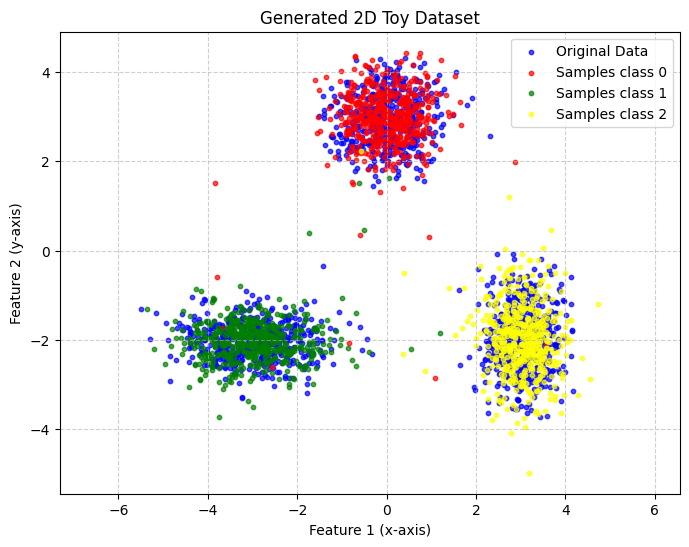

In [14]:
from spflow.meta.dispatch import SamplingContext

n_samples = 500
out_features = rat.out_features
num_features = 2

evidence = torch.full((n_samples, num_features), torch.nan)
channel_index = torch.full((n_samples, out_features), 0, dtype=torch.int64)
mask = torch.full((n_samples, out_features), True, dtype=torch.bool)
sampling_ctx = SamplingContext(channel_index=channel_index, mask=mask)
samples_class0 = sample(rat, evidence, sampling_ctx=sampling_ctx)

evidence = torch.full((n_samples, num_features), torch.nan)
channel_index = torch.full((n_samples, out_features), 1, dtype=torch.int64)
mask = torch.full((n_samples, out_features), True, dtype=torch.bool)
sampling_ctx = SamplingContext(channel_index=channel_index, mask=mask)
samples_class1 = sample(rat, evidence, sampling_ctx=sampling_ctx)

evidence = torch.full((n_samples, num_features), torch.nan)
channel_index = torch.full((n_samples, out_features), 2, dtype=torch.int64)
mask = torch.full((n_samples, out_features), True, dtype=torch.bool)
sampling_ctx = SamplingContext(channel_index=channel_index, mask=mask)
samples_class2 = sample(rat, evidence, sampling_ctx=sampling_ctx)


plt.figure(figsize=(8, 6))
# We use a scatter plot. data_np[:, 0] is the x-axis, data_np[:, 1] is the y-axis
plt.scatter(data_np[:, 0], data_np[:, 1], s=10, alpha=0.7, c='blue', label='Original Data')
plt.scatter(samples_class0[:, 0], samples_class0[:, 1], s=10, alpha=0.7, c='red', label='Samples class 0')
plt.scatter(samples_class1[:, 0], samples_class1[:, 1], s=10, alpha=0.7, c='green', label='Samples class 1')
plt.scatter(samples_class2[:, 0], samples_class2[:, 1], s=10, alpha=0.7, c='yellow', label='Samples class 2')
plt.title('Generated 2D Toy Dataset')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal') # Ensures the scaling is the same on both axes
plt.legend()
plt.show()

However, the model can of course also be used for classification. As an example, we visualize the trained decision boundaries of our model

torch.Size([90000, 1, 3])
tensor([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]])


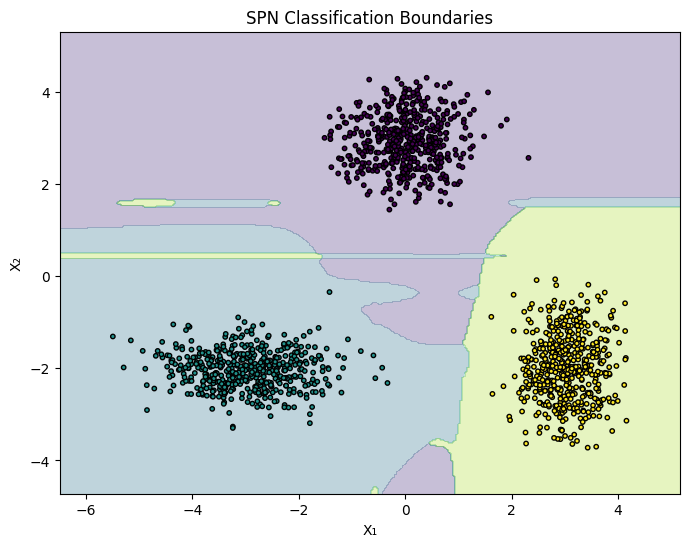

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# --- Assuming your dataset and labels are already created as above ---

# Let's assume you have an SPN model trained on this data:
# For example:
# spn = MySPNModel()
# spn.fit(dataset, labels)

# --- 1. Create a grid of points over the feature space ---
x_min, x_max = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
y_min, y_max = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1

xx, yy = torch.meshgrid(
    torch.linspace(x_min, x_max, 300),
    torch.linspace(y_min, y_max, 300),
    indexing='xy'
)
grid_points = torch.stack([xx.flatten(), yy.flatten()], dim=1)

# --- 2. Get SPN predictions (probabilities or class scores) ---
# Example: if your SPN returns class probabilities
with torch.no_grad():
    probs = log_likelihood(rat.root_node.inputs, grid_points) # shape: [N_grid, num_classes]
    print(probs.shape)
    preds = probs.argmax(dim=-1)
    print(preds)

# --- 3. Reshape predictions to match the grid ---
Z = preds.reshape(xx.shape)

# --- 4. Plot decision boundaries ---
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, levels=len(means), cmap="viridis")

# Plot the original data
plt.scatter(dataset[:, 0], dataset[:, 1], c=labels, cmap="viridis", s=10, edgecolor="k")

plt.title("SPN Classification Boundaries")
plt.xlabel("X₁")
plt.ylabel("X₂")
plt.show()


## LearnSPN
Instead of creating a random structure, we can also train the SPN structure using the LearnSPN. 

In [16]:
from spflow.learn.learn_spn import learn_spn
scope = Scope(list(range(2)))
normal_layer = Normal(scope=scope, out_channels=4)
learn_spn = learn_spn(
    torch.tensor(dataset, dtype=torch.float32),
    leaf_modules=normal_layer,
    out_channels=1,
    min_instances_slice=70,
    min_features_slice = 2
)
learn_spn

used 3 iterations (0.009s) to cluster 1500 items into 2 clusters
used 4 iterations (0.004s) to cluster 1000 items into 2 clusters


C:\Users\alex_\AppData\Local\Temp\ipykernel_29228\3209010222.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(dataset, dtype=torch.float32),
F:\Pycharm\PycharmProjects\SPFlowTorch\spflow\learn\learn_spn.py:366: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3729.)
  weights = torch.tensor(w).T.unsqueeze(0).unsqueeze(-1)  # shape(1, num_clusters, 1)


Sum(
  D=1, C=1, R=None, weights=(1, 5, 1)
  (inputs): Cat(
    D=1, C=5, R=None, dim=2
    (inputs): ModuleList(
      (0): Product(
        D=1, C=4, R=None
        (inputs): Cat(
          D=2, C=4, R=None, dim=1
          (inputs): ModuleList(
            (0-1): 2 x Normal(
              D=1, C=4, R=None
              (distribution): Normal()
            )
          )
        )
      )
      (1): Sum(
        D=1, C=1, R=None, weights=(1, 8, 1)
        (inputs): Cat(
          D=1, C=8, R=None, dim=2
          (inputs): ModuleList(
            (0-1): 2 x Product(
              D=1, C=4, R=None
              (inputs): Cat(
                D=2, C=4, R=None, dim=1
                (inputs): ModuleList(
                  (0-1): 2 x Normal(
                    D=1, C=4, R=None
                    (distribution): Normal()
                  )
                )
              )
            )
          )
        )
      )
    )
  )
)

The trained SPN can now be used just like any other module

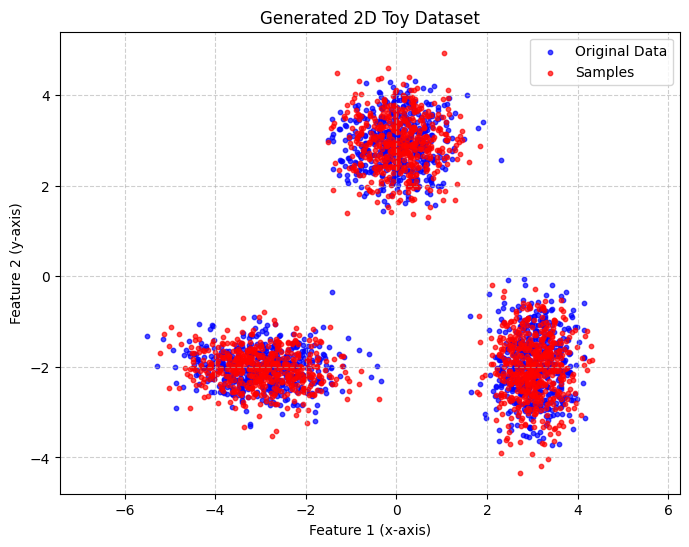

In [17]:
learn_spn_samples = sample(spn, 1500)

plt.figure(figsize=(8, 6))
# We use a scatter plot. data_np[:, 0] is the x-axis, data_np[:, 1] is the y-axis
plt.scatter(data_np[:, 0], data_np[:, 1], s=10, alpha=0.7, c='blue', label='Original Data')
plt.scatter(samples[:, 0], samples[:, 1], s=10, alpha=0.7, c='red', label='Samples')
plt.title('Generated 2D Toy Dataset')
plt.xlabel('Feature 1 (x-axis)')
plt.ylabel('Feature 2 (y-axis)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.axis('equal') # Ensures the scaling is the same on both axes
plt.legend()
plt.show()